imports

In [1]:
import torch
import os
import numpy as np
from tqdm import tqdm

import pandas as pd

from myhelpers import cifar_dataLoader

from HGNN.train.configParser import ConfigParser
from HGNN.train import CNN, dataLoader
from myhelpers.memory import get_cuda_memory
from myhelpers.image_show import showExample, getClosestImageFromDataloader
from myhelpers.images_tsne import get_tsne
from misc import get_classification_df

experimetnsFileName = "experiments.csv"

parameters

In [2]:
experimentsPath="/raid/elhamod/Fish/experiments/"
dataPath="/raid/elhamod/Fish/"
experimentName="Fish-L1-experiment2"#"CIFAR_phylogeny_HGNN_lambdaExperiment"
trial_hash="27a4da8bf0c3bca7096cddf192ecf3069e035ad3fbba69bbd47bd157" #MSE + L1
#"5922bad3c69f629daa0af24121e292a895f308e7cae3ec4f64536186"#hier

legends=['fine', 'coarse']
use_submodel=True
dataset_name="test"
cuda=0
batch_size = 4
num_workers = 8

cuda

In [3]:
# set cuda
if torch.cuda.is_available():
    torch.cuda.set_device(cuda)
    print("using cuda", cuda)
    
torch.multiprocessing.set_start_method('spawn')

using cuda 0


Get dataset

In [4]:
# Get experiment parameters
experimentsFileNameAndPath = os.path.join(experimentsPath, experimetnsFileName)
if os.path.exists(experimentsFileNameAndPath):
    experiments_df = pd.read_csv(experimentsFileNameAndPath)
    experiments_df = experiments_df.where(pd.notnull(experiments_df), None)
else:
    raise Exception("Experiment not " + trial_hash + " found!")
experimentRecord = experiments_df[experiments_df["trialHash"] == trial_hash]
experiment_params = experimentRecord.to_dict('records')[0]
print(experiment_params)

config_parser = ConfigParser(experimentsPath, dataPath, experimentName)
experimentPathAndName = os.path.join(experimentsPath, experimentName)
if experiment_params['image_path'] == 'cifar-100-python':
    datasetManager = cifar_dataLoader.datasetManager(experimentPathAndName, dataPath)
else:
    datasetManager = dataLoader.datasetManager(experimentPathAndName, dataPath)
datasetManager.updateParams(config_parser.fixPaths(experiment_params))
train_loader, validation_loader, test_loader = datasetManager.getLoaders()

dataloader = torch.utils.data.DataLoader(test_loader.dataset if dataset_name=="test" else train_loader.dataset, pin_memory=True, batch_size=batch_size, num_workers=num_workers)
dataset = dataloader.dataset

{'experimentName': 'Fish-L1-experiment2', 'modelName': 'models/27a4da8bf0c3bca7096cddf192ecf3069e035ad3fbba69bbd47bd157', 'datasetName': 'datasplits/7c7513bdfb4e5577fef1c3ec0fa6452d30d87dbc95f258a7c86dd76b', 'experimentHash': 'acc407e67427c9aa8017e394264d6dca69a5570834ffa307fca452a2', 'trialHash': '27a4da8bf0c3bca7096cddf192ecf3069e035ad3fbba69bbd47bd157', 'image_path': 'Curated4/Easy_50', 'suffix': None, 'img_res': 448, 'augmented': True, 'batchSize': 128, 'learning_rate': 0.001, 'numOfTrials': 1, 'fc_layers': 1, 'modelType': 'BB', 'lambda': 0.01, 'unsupervisedOnTest': None, 'tl_model': 'ResNet18', 'link_layer': 'avgpool', 'adaptive_smoothing': False, 'adaptive_lambda': 0.1, 'adaptive_alpha': 0.5, 'noSpeciesBackprop': False, 'phylogeny_loss': 'MSE', 'phylogeny_loss_epsilon': 0.03, 'tripletEnabled': False, 'tripletSamples': 2.0, 'tripletSelector': 'semihard', 'tripletMargin': 2.0, 'displayName': 'Fish-L1_2-MSE', 'pretrained': True, 'epochs': 80.0, 'patience': -1.0, 'optimizer': 'adabel

Get untrained model

In [5]:
%%capture

architecture = {
    "fine": len(dataset.csv_processor.getFineList()),
    "coarse" : len(dataset.csv_processor.getCoarseList())
}
model = CNN.create_model(architecture, experiment_params, cuda)

# get the model and the parameters
modelName = experimentRecord.iloc[0]["modelName"]
trialName = os.path.join(experimentPathAndName, modelName)
_ = CNN.loadModel(model, trialName)
model.eval()

Show example and closest images

Show TSNE

100%|██████████| 95/95 [00:07<00:00, 12.25it/s]


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 380 samples in 0.003s...
[t-SNE] Computed neighbors for 380 samples in 0.038s...
[t-SNE] Computed conditional probabilities for sample 380 / 380
[t-SNE] Mean sigma: 34.658041
[t-SNE] Computed conditional probabilities in 0.036s
[t-SNE] Iteration 50: error = 68.3643112, gradient norm = 0.5690301 (50 iterations in 0.190s)
[t-SNE] Iteration 100: error = 68.2992401, gradient norm = 0.5740179 (50 iterations in 0.040s)
[t-SNE] Iteration 150: error = 71.7793808, gradient norm = 0.5150326 (50 iterations in 0.040s)
[t-SNE] Iteration 200: error = 72.5558777, gradient norm = 0.5447557 (50 iterations in 0.041s)
[t-SNE] Iteration 250: error = 71.5343018, gradient norm = 0.5420324 (50 iterations in 0.041s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.534302
[t-SNE] Iteration 300: error = 0.9551047, gradient norm = 0.0050492 (50 iterations in 0.038s)
[t-SNE] Iteration 350: error = 0.8686952, gradient norm = 0.0014740 

100%|██████████| 95/95 [00:05<00:00, 17.24it/s]


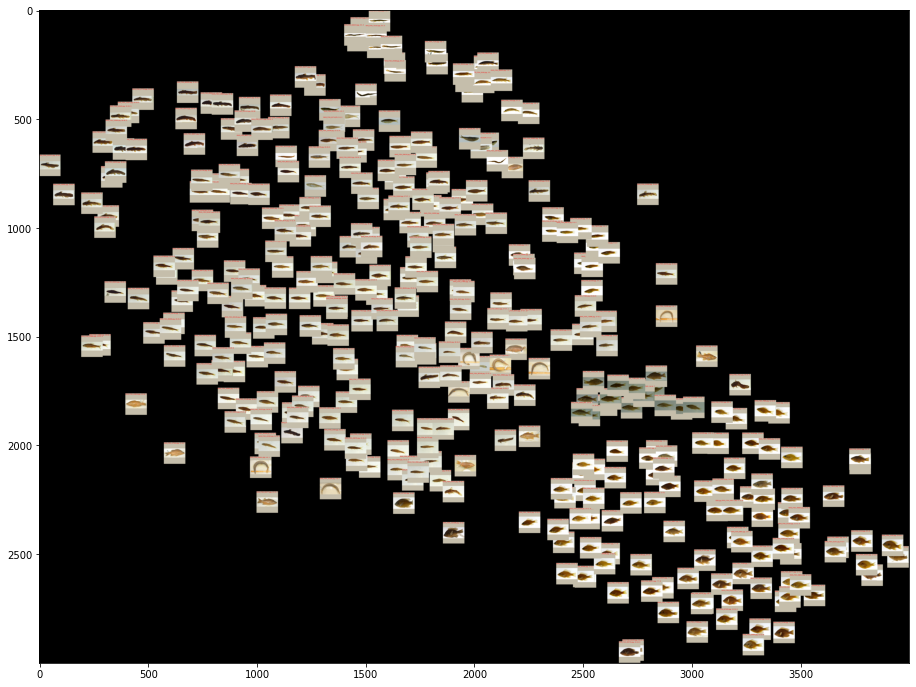

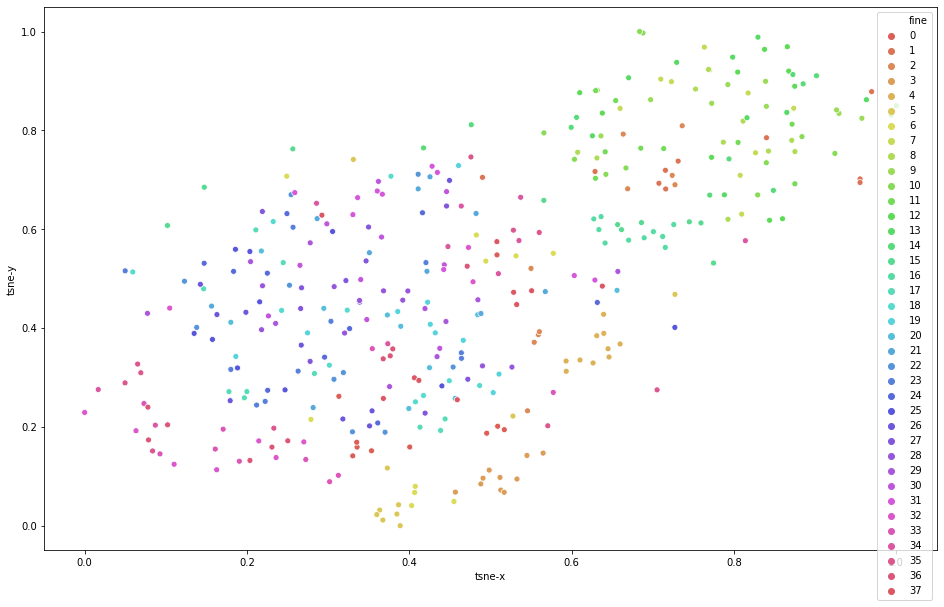

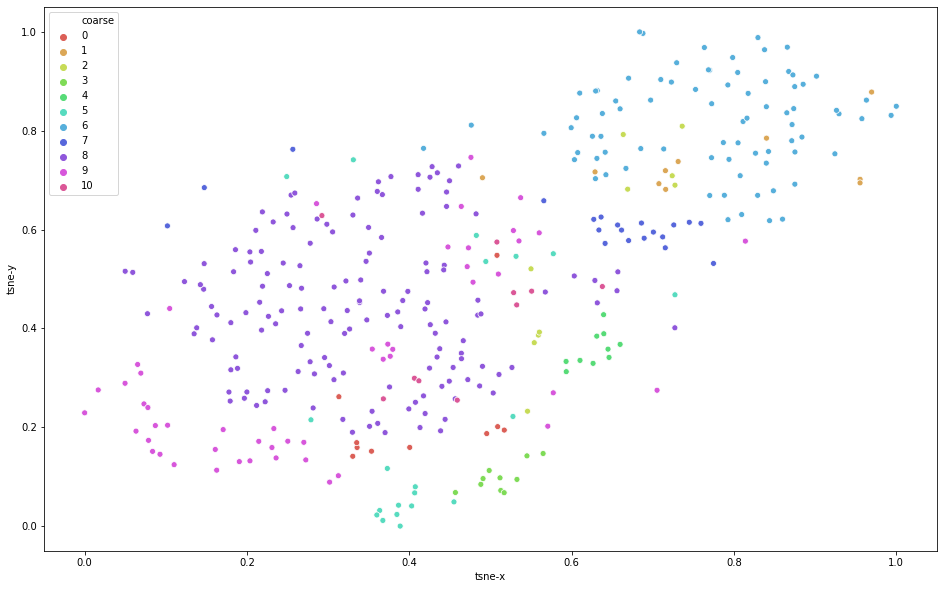

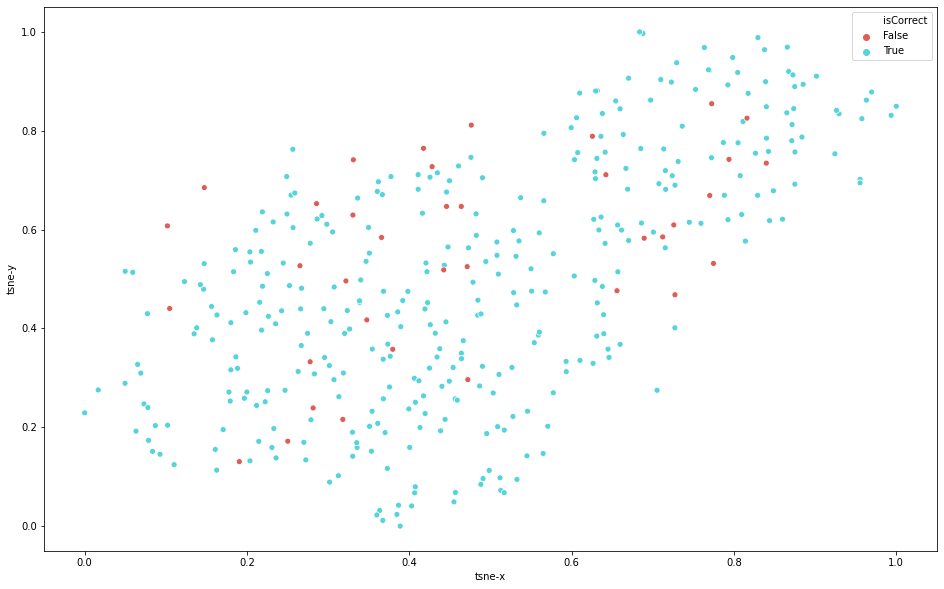

In [6]:
activation_layer = 'layer2'#'fine'

model_sub = model
if hasattr(model, 'network_fine') and use_submodel==True:
    model_sub = model.network_fine

get_tsne(dataloader, model_sub, activation_layer, experiment_params['img_res'], 
                os.path.join(experimentPathAndName, modelName), 
                dataset_name+"_"+activation_layer+("_submodule" if use_submodel==True else ""), legends, cuda)

100%|██████████| 95/95 [00:06<00:00, 15.41it/s]


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 380 samples in 0.002s...
[t-SNE] Computed neighbors for 380 samples in 0.028s...
[t-SNE] Computed conditional probabilities for sample 380 / 380
[t-SNE] Mean sigma: 25.292135
[t-SNE] Computed conditional probabilities in 0.026s
[t-SNE] Iteration 50: error = 67.3159561, gradient norm = 0.5364042 (50 iterations in 0.048s)
[t-SNE] Iteration 100: error = 68.7096634, gradient norm = 0.5411083 (50 iterations in 0.044s)
[t-SNE] Iteration 150: error = 66.9277725, gradient norm = 0.5565466 (50 iterations in 0.043s)
[t-SNE] Iteration 200: error = 67.7938690, gradient norm = 0.5414104 (50 iterations in 0.043s)
[t-SNE] Iteration 250: error = 68.2454834, gradient norm = 0.5168893 (50 iterations in 0.049s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.245483
[t-SNE] Iteration 300: error = 0.5157287, gradient norm = 0.0105435 (50 iterations in 0.040s)
[t-SNE] Iteration 350: error = 0.4103411, gradient norm = 0.0055036 

100%|██████████| 95/95 [00:05<00:00, 16.61it/s]


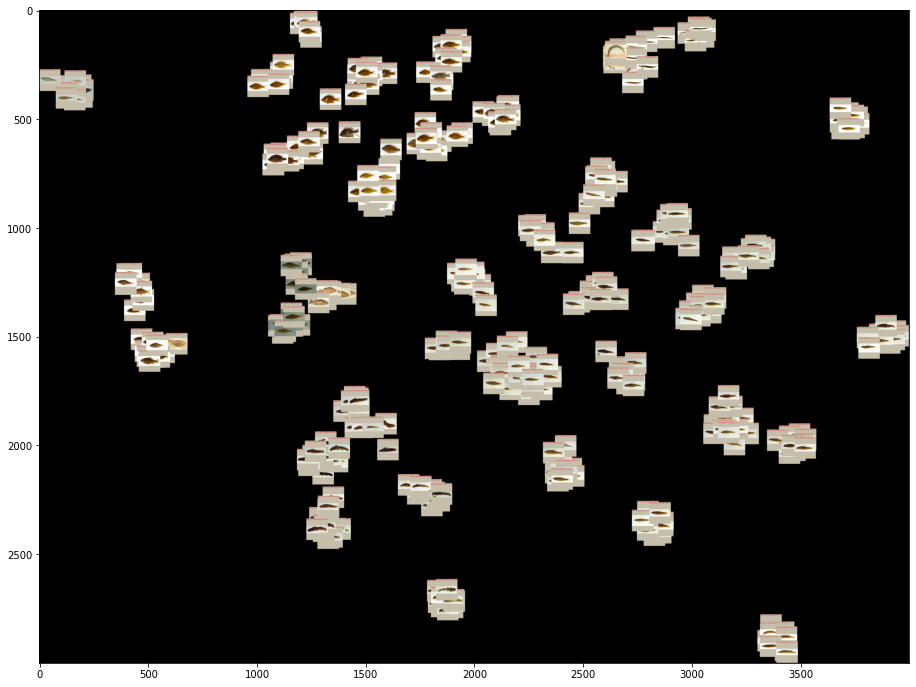

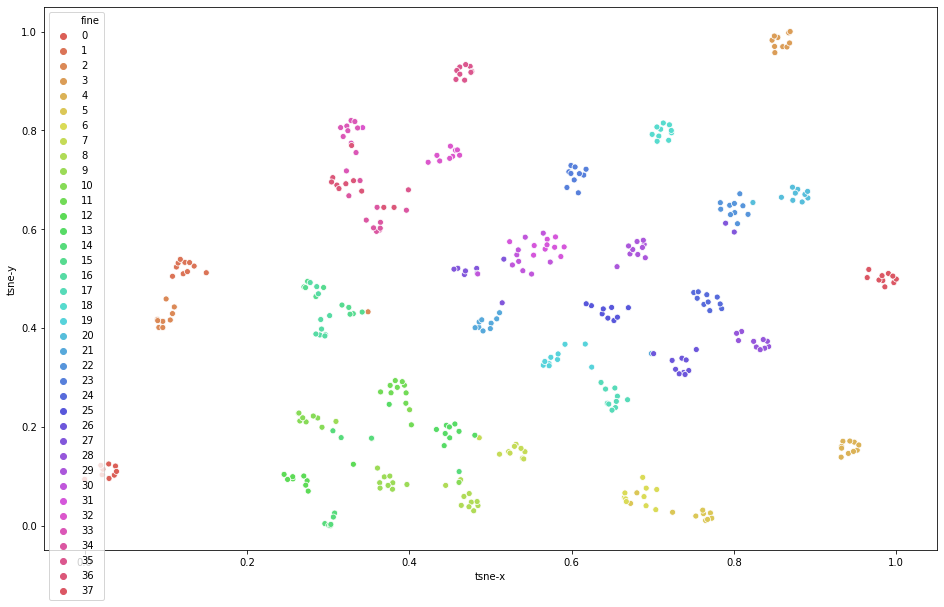

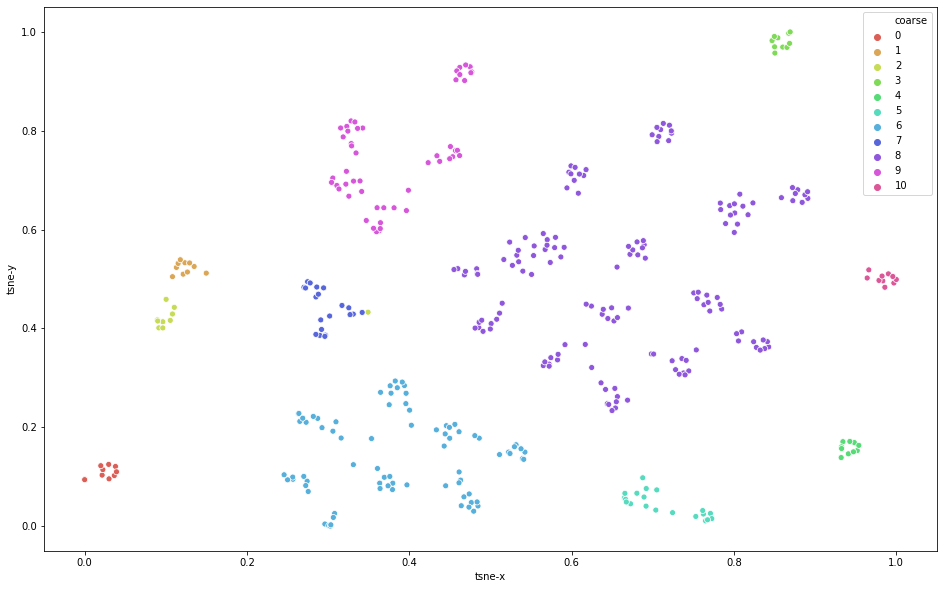

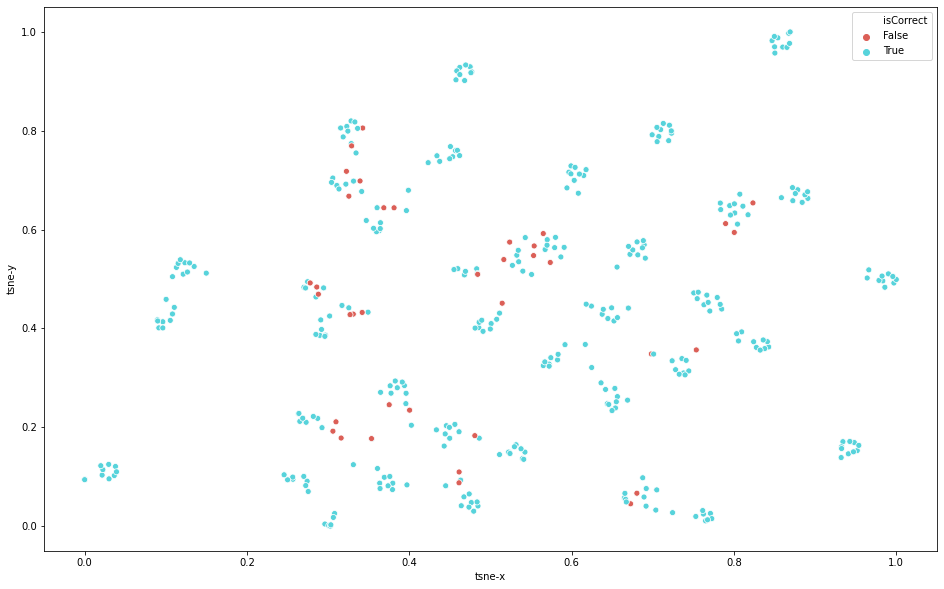

In [7]:
activation_layer = 'layer4'#'fine'

get_tsne(dataloader, model_sub, activation_layer, experiment_params['img_res'], 
                os.path.join(experimentPathAndName, modelName), 
                dataset_name+"_"+activation_layer+("_submodule" if use_submodel==True else ""), legends, cuda)

100%|██████████| 95/95 [00:06<00:00, 15.21it/s]


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 380 samples in 0.003s...
[t-SNE] Computed neighbors for 380 samples in 0.023s...
[t-SNE] Computed conditional probabilities for sample 380 / 380
[t-SNE] Mean sigma: 10.790795
[t-SNE] Computed conditional probabilities in 0.030s
[t-SNE] Iteration 50: error = 64.7213821, gradient norm = 0.5539034 (50 iterations in 0.183s)
[t-SNE] Iteration 100: error = 65.9892197, gradient norm = 0.5448065 (50 iterations in 0.312s)
[t-SNE] Iteration 150: error = 66.1642303, gradient norm = 0.5279243 (50 iterations in 0.200s)
[t-SNE] Iteration 200: error = 66.3517761, gradient norm = 0.5312086 (50 iterations in 0.374s)
[t-SNE] Iteration 250: error = 67.1771469, gradient norm = 0.5292960 (50 iterations in 0.355s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.177147
[t-SNE] Iteration 300: error = 0.4084526, gradient norm = 0.0036351 (50 iterations in 0.405s)
[t-SNE] Iteration 350: error = 0.3825617, gradient norm = 0.0003872 

100%|██████████| 95/95 [00:05<00:00, 17.63it/s]


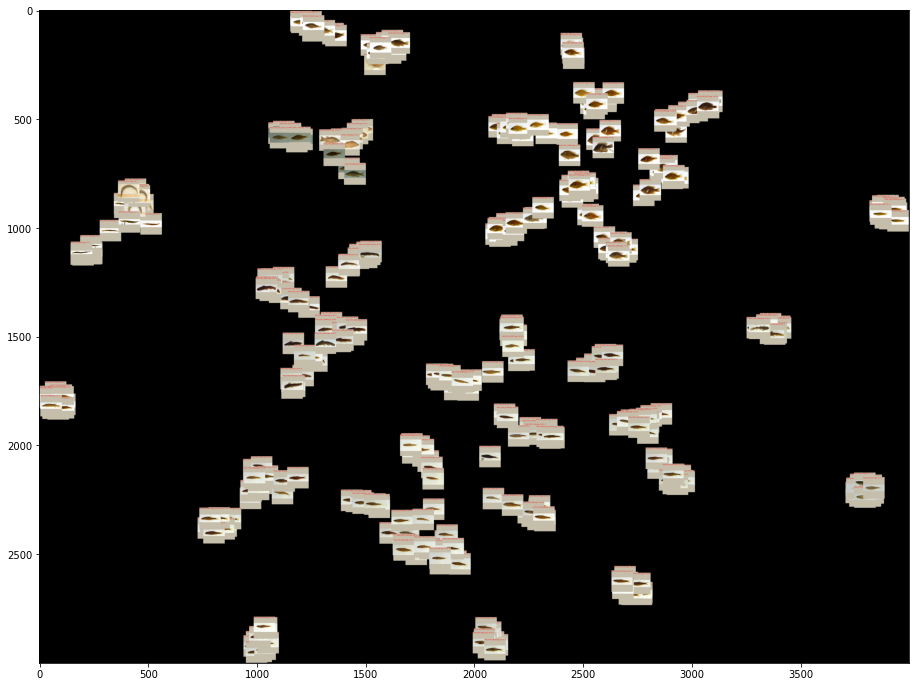

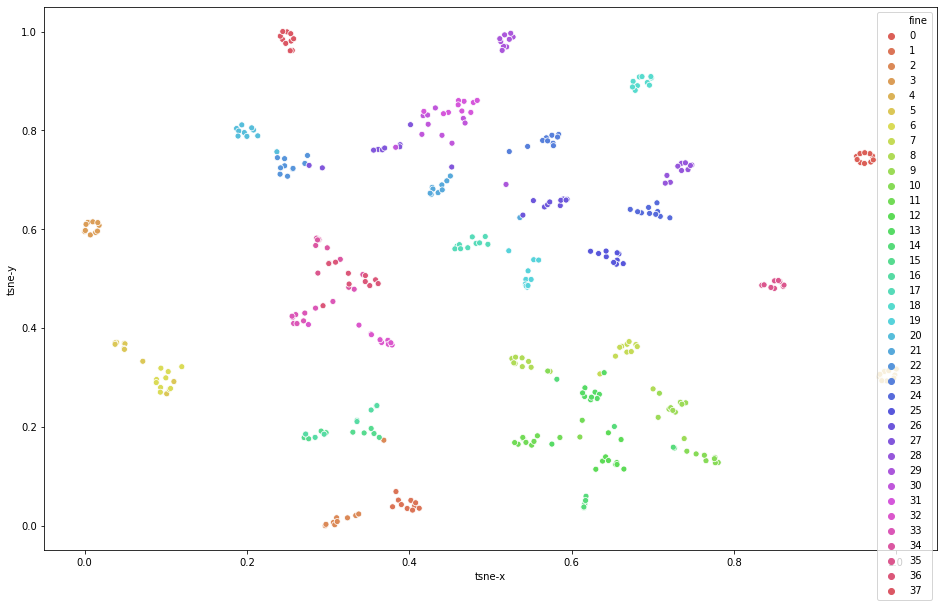

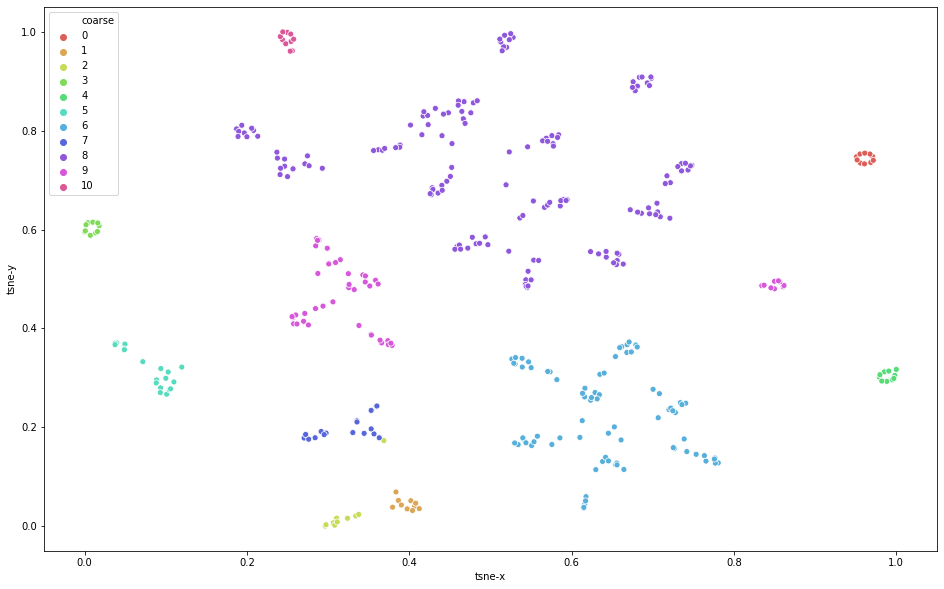

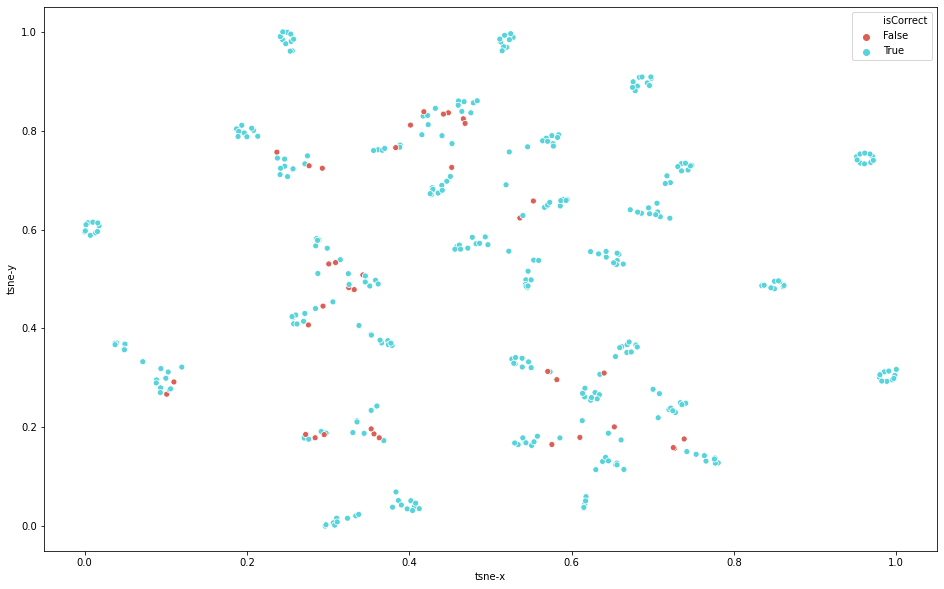

In [8]:
activation_layer = 'fine'#'fine'

get_tsne(dataloader, model_sub, activation_layer, experiment_params['img_res'], 
                os.path.join(experimentPathAndName, modelName), 
                dataset_name+"_"+activation_layer+("_submodule" if use_submodel==True else ""), legends, cuda)